<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_15).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Consumo Electrico Residencial)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','ConsumResidencial']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4161 entries, 4380 to 8540
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   4161 non-null   int64  
 1   Trimestre             4161 non-null   int64  
 2   Mes                   4161 non-null   int64  
 3   Codi_Districte        4161 non-null   int64  
 4   Nom_Districte         4161 non-null   object 
 5   Codi_Barri            4161 non-null   int64  
 6   Nom_Barri             4161 non-null   object 
 7   Compraventa_Unitario  4161 non-null   float64
 8   ConsumResidencial     4161 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 325.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ConsumResidencial
Fecha,,,,,,,,,
2019-01-01,2019,1,1,1,Ciutat Vella,1,el Raval,3775.1,18828371.0
2019-02-01,2019,1,2,1,Ciutat Vella,1,el Raval,3775.1,15384687.0
2019-03-01,2019,1,3,1,Ciutat Vella,1,el Raval,3775.1,14925799.0
2019-04-01,2019,2,4,1,Ciutat Vella,1,el Raval,3838.4,13804105.0
2019-05-01,2019,2,5,1,Ciutat Vella,1,el Raval,3838.4,13852496.0


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2019-01-01,2242.453846,7.494965e+06
2019-02-01,2242.453846,5.868452e+06
2019-03-01,2242.453846,6.572881e+06
2019-04-01,2145.500000,5.090359e+06
2019-05-01,2145.500000,4.992917e+06


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2019-01-01 to 2023-09-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  57 non-null     float64
 1   ConsumResidencial     57 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB


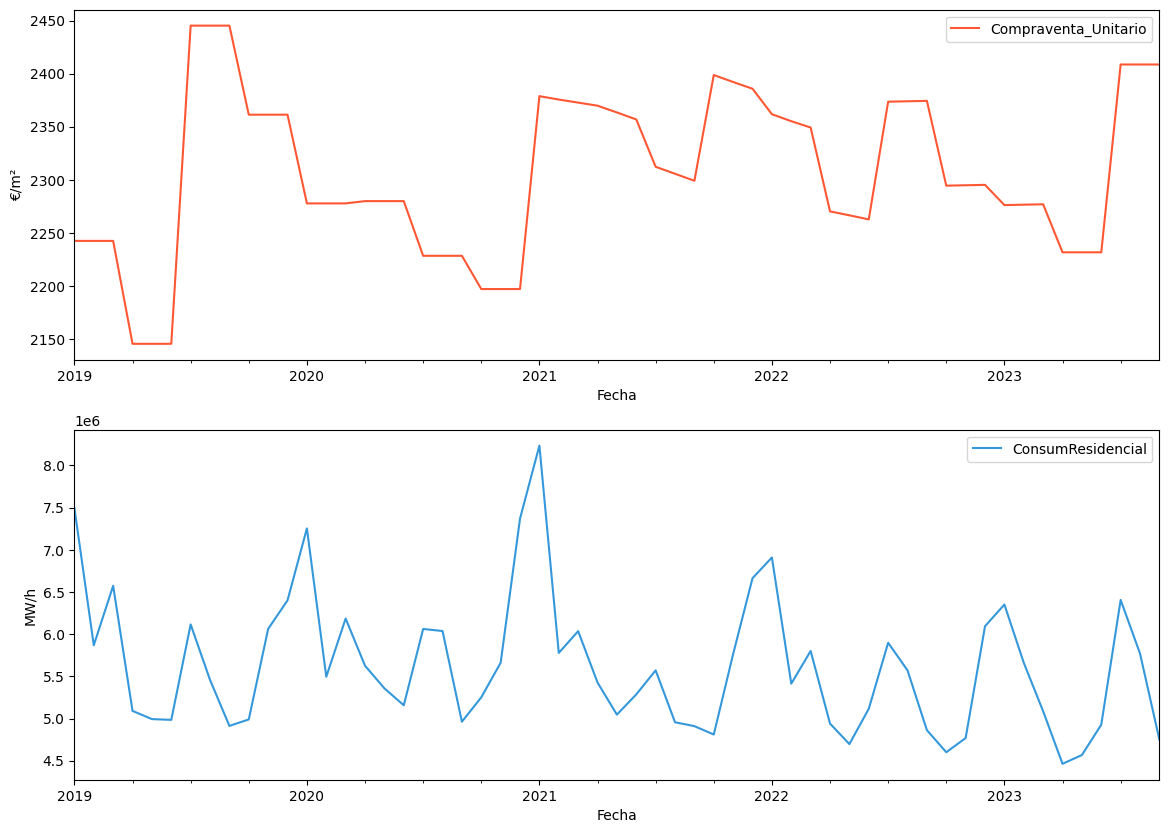

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'MW/h']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,ConsumResidencial
Compraventa_Unitario,1.000000,0.114702
ConsumResidencial,0.114702,1.000000


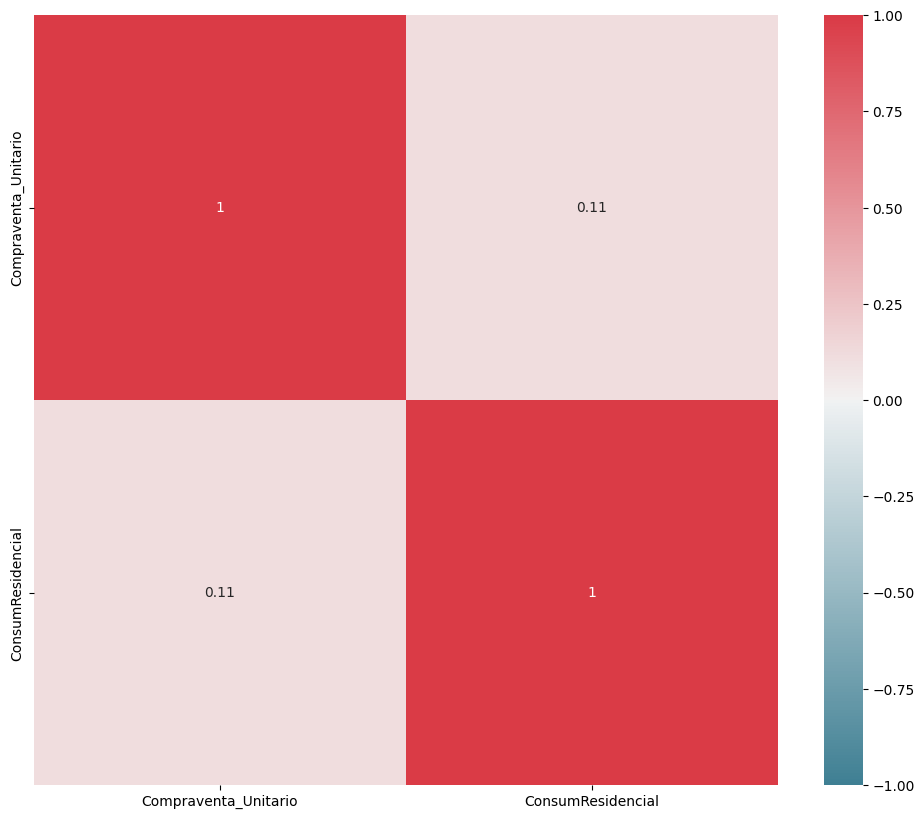

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "ConsumResidencial" es de 0.114702, lo que sugiere una correlación positiva moderada entre estas dos variables en tu modelo.

### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [17]:
fecha_division = '2023-04-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(51, 2) (6, 2)


###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario','ConsumResidencial']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  9.65      > 12.3212   =>   False
ConsumResidencial >  0.02      > 4.1296    =>   False


* **Compraventa_Unitario**: No hay suficiente evidencia estadística para rechazar la hipótesis nula de no cointegración. Esto sugiere que "Compraventa_Unitario" no tiene una relación de equilibrio estacionario de largo plazo con las otras series en el sistema.
* **ConsumResidencial** : Similarmente, "ConsumResidencial " tampoco muestra evidencia de cointegración. No existe una combinación lineal estacionaria que vincule esta serie con otras en el sistema a largo plazo.

Para un análisis conjunto que aún considera las interacciones entre múltiples series no cointegradas, usaremos un modelo VAR (Vector Autoregressive) o VARMA (Vector Autoregressive Moving Average) y descartaremos el modelo VECM (Vector Error Correlation Model), pero primero transformaremos comprobaremos y transformaremos por diferenciacion las veces necesrarias para convertir las series en estacionarias



### Prueba de estacionariedad

Un requisito indispensable para poder aplicar los modelo, es que los datos sean estacionarios. Para comprobarlo realizaremos el Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.



In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.025842
Serie de tiempo ConsumResidencial
p-value: 0.984715


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2019-02-01,0.000000,-1.626513e+06
2019-03-01,0.000000,7.044295e+05
2019-04-01,-96.953846,-1.482522e+06
2019-05-01,0.000000,-9.744262e+04
2019-06-01,0.000000,-8.845385e+03


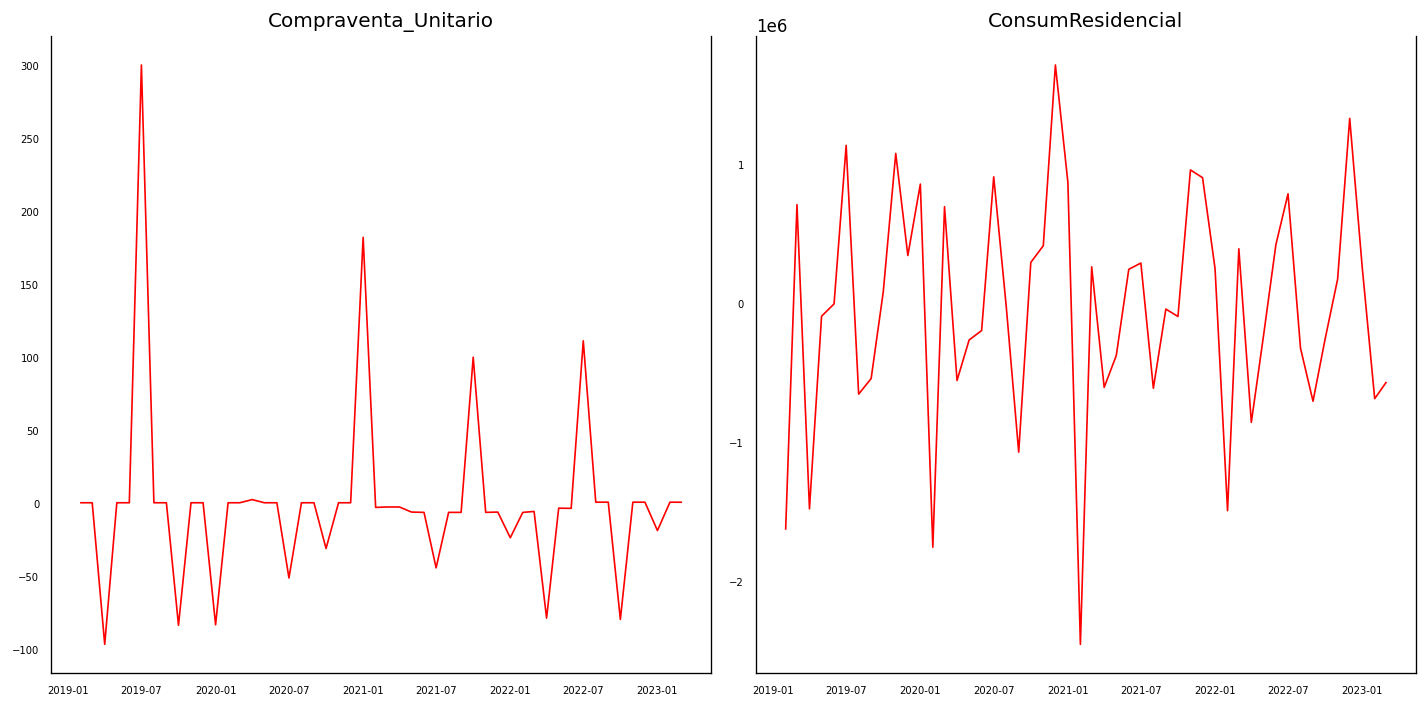

In [23]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable ConsumResidencial
p-value: 0.029199


Los p-valores son menores que 0.05, con lo cual se rechaza la hipótesis nula de que la serie no es estacionaria, por lo que esta serie es estacionaria

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola serie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de sus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




In [25]:
from statsmodels.tsa.api import VAR

In [26]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [27]:
modelsel=model.select_order(8)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,34.96*,35.04*,1.527e+15*,34.99*
1,35.04,35.29,1.659e+15,35.14
2,35.19,35.60,1.913e+15,35.34
3,35.16,35.73,1.865e+15,35.37
4,35.29,36.04,2.157e+15,35.57
5,35.45,36.36,2.548e+15,35.78
6,35.28,36.36,2.189e+15,35.67
7,35.36,36.60,2.434e+15,35.82
8,35.52,36.93,2.949e+15,36.04


Para seleccionar el orden adecuado en un modelo VAR (Vector Autoregression), generalmente se busca minimizar los criterios de información como el AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), FPE (Final Prediction Error) y HQIC (Hannan-Quinn Information Criterion). En nuestos datos el orden óptimo parece ser el modelo VAR(1), ya que tiene los valores más bajos en los criterios AIC, BIC y FPE, y uno de los valores más bajos en HQIC.


#### Ajustando el modelo

In [28]:
res = model.fit(maxlags=1)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, May, 2024
Time:                     18:04:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    35.8125
Nobs:                     49.0000    HQIC:                   35.6688
Log likelihood:          -1004.79    FPE:                2.83606e+15
AIC:                      35.5809    Det(Omega_mle):     2.51826e+15
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           1.111541         9.062054            0.123           0.902
L1.Compraventa_Unitario        -0.038289         0.151141           -0.253           0.800
L1.Co

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "ConsumResidencial" es de 0.275881, lo que sugiere una correlación positiva moderada entre los residuos de estas dos variables en tu modelo.

In [29]:
res.is_stable()

True

In [30]:
X_train_transformed.columns

Index(['Compraventa_Unitario', 'ConsumResidencial'], dtype='object')

###### Causalidad de Granger

In [31]:
grangercaus=res.test_causality(['ConsumResidencial'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.141,3.945,0.288,"(1, 92)"


In [32]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['ConsumResidencial'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.8479,3.945,0.360,"(1, 92)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=15
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,ConsumResidencial_x
Compraventa_Unitario_y,1.0,0.0
ConsumResidencial_y,0.0,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

#### Diagnosis del modelo


###### Residuos

In [34]:
residuals=res.resid

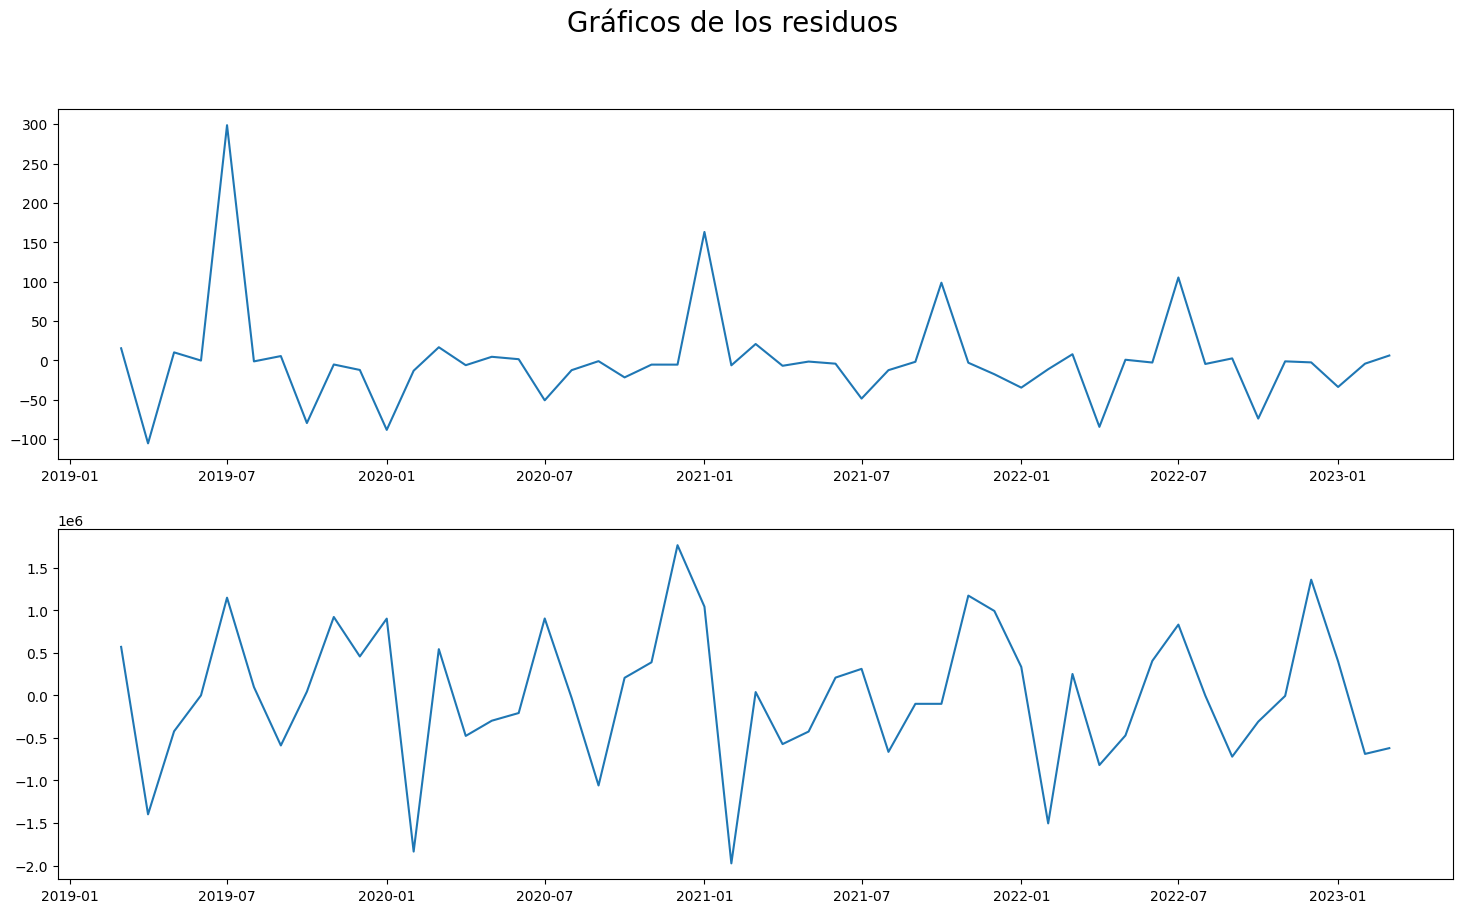

In [35]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [36]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[1.3841407027612051e-09, 0.05399419807589107]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


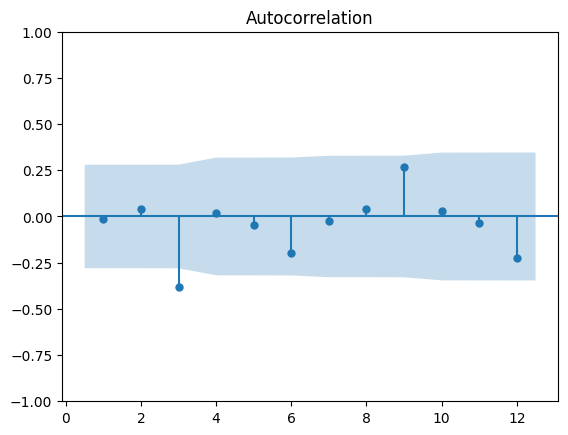

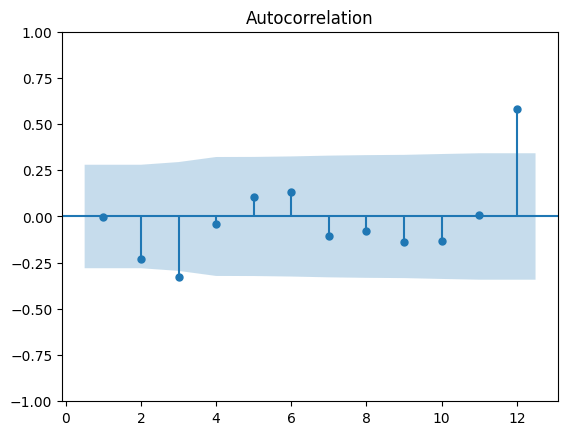

In [37]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 12 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:

Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.



In [38]:
res = model.fit(12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, May, 2024
Time:                     18:04:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    35.9977
Nobs:                     38.0000    HQIC:                   34.6096
Log likelihood:          -700.855    FPE:                8.42785e+14
AIC:                      33.8429    Det(Omega_mle):     3.06622e+14
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            1.622161         7.045634            0.230           0.818
L1.Compraventa_Unitario         -0.065039         0.211726           -0.307           0.759
L

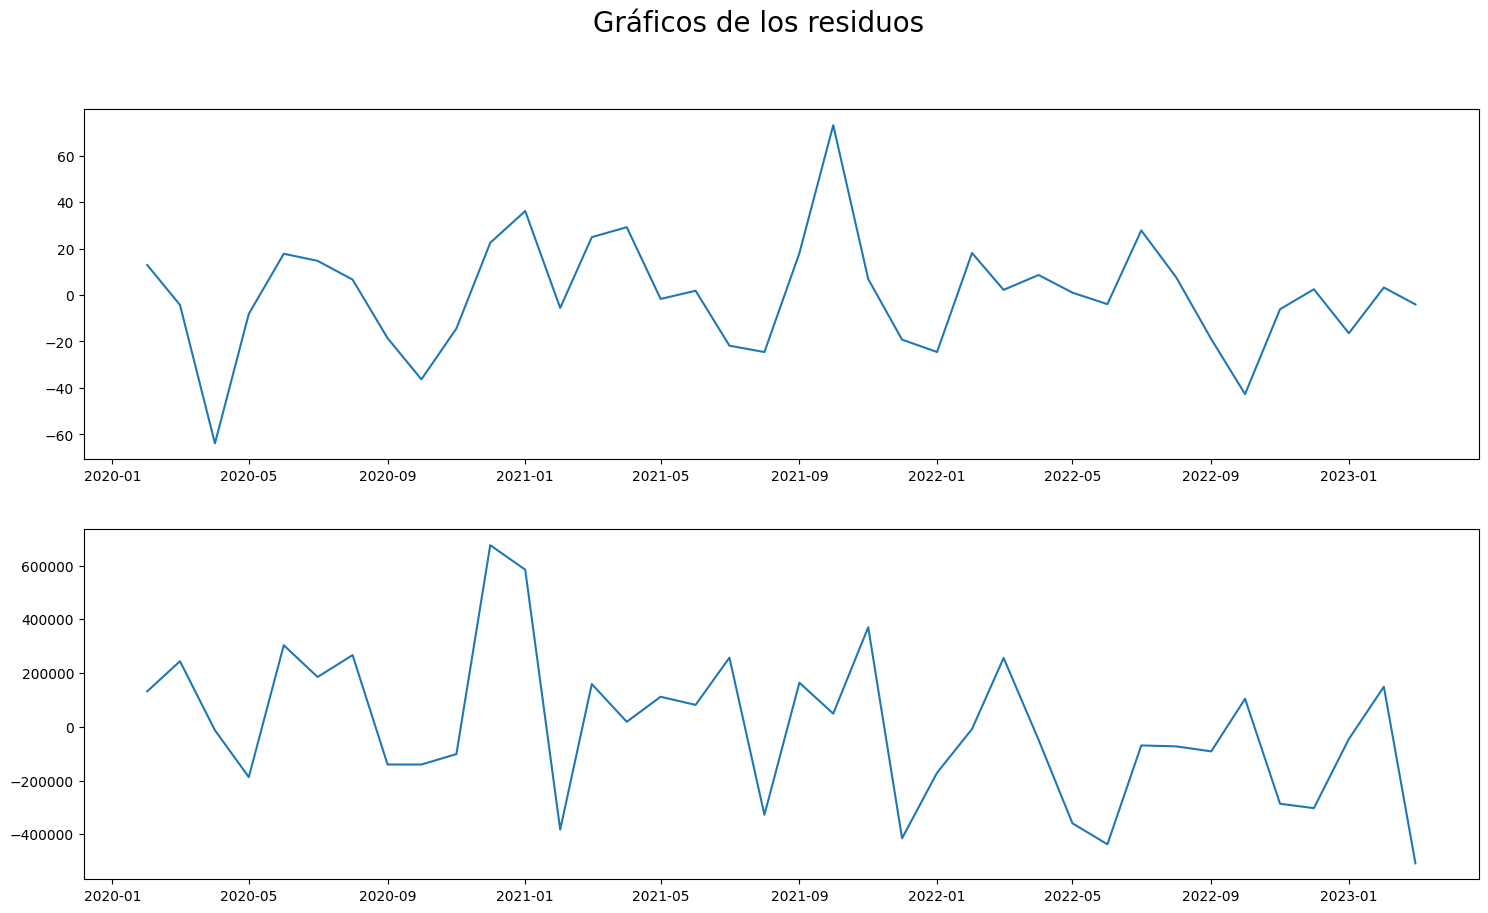

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

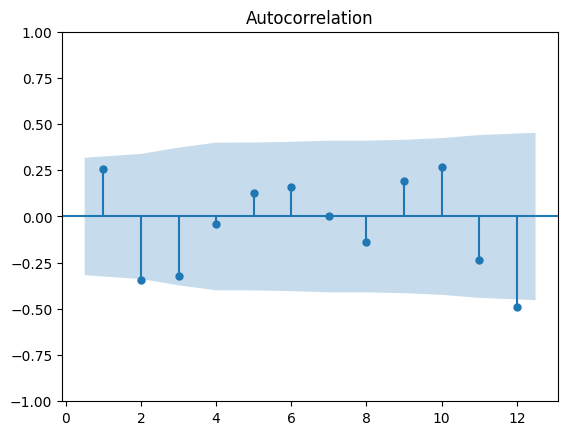

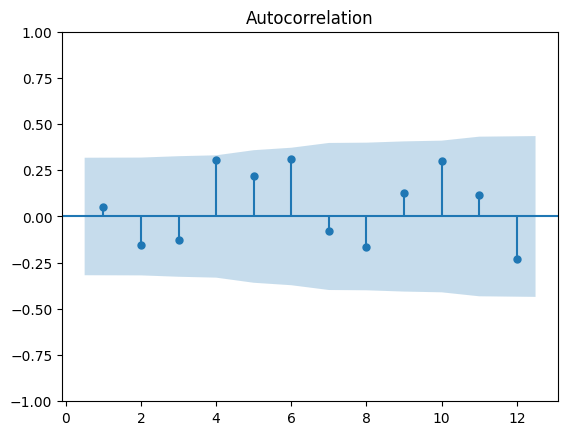

In [40]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 12, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

#### Valores predichos


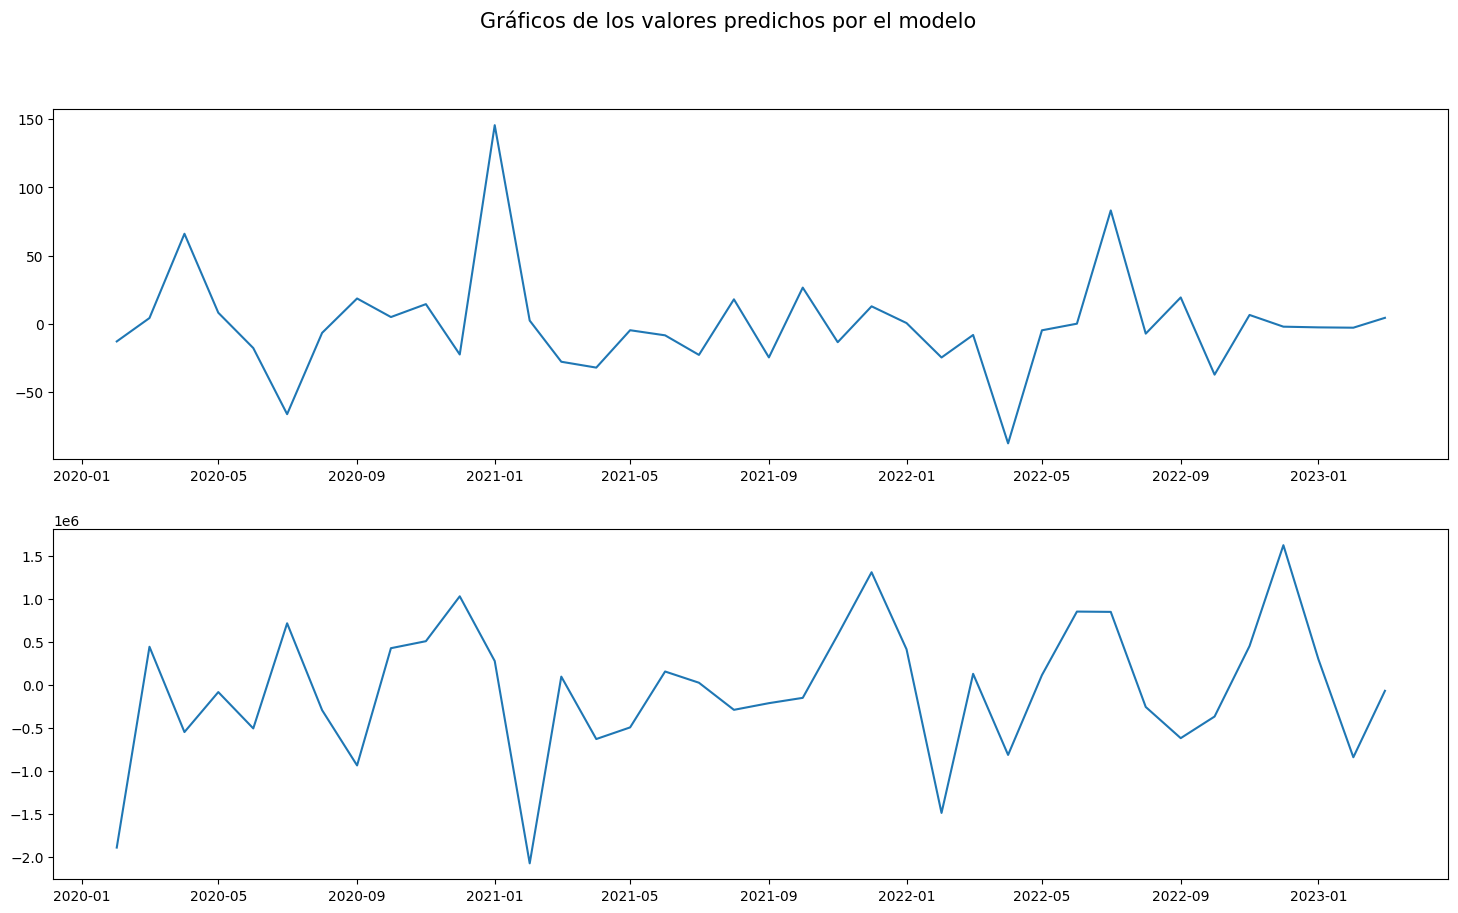

In [41]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [42]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=6)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns))
print('Predicciones:')
pred

Orden del modelo: 12
Predicciones:


,Compraventa_Unitario,ConsumResidencial
Fecha,,
2023-04-01,52.563831,243296.523670
2023-05-01,-22.219911,-262629.963159
2023-06-01,10.829629,115708.132251
2023-07-01,-24.103404,453899.670654
2023-08-01,19.618294,-228391.904458
2023-09-01,-18.273932,-443371.377171


<Figure size 1200x1000 with 0 Axes>

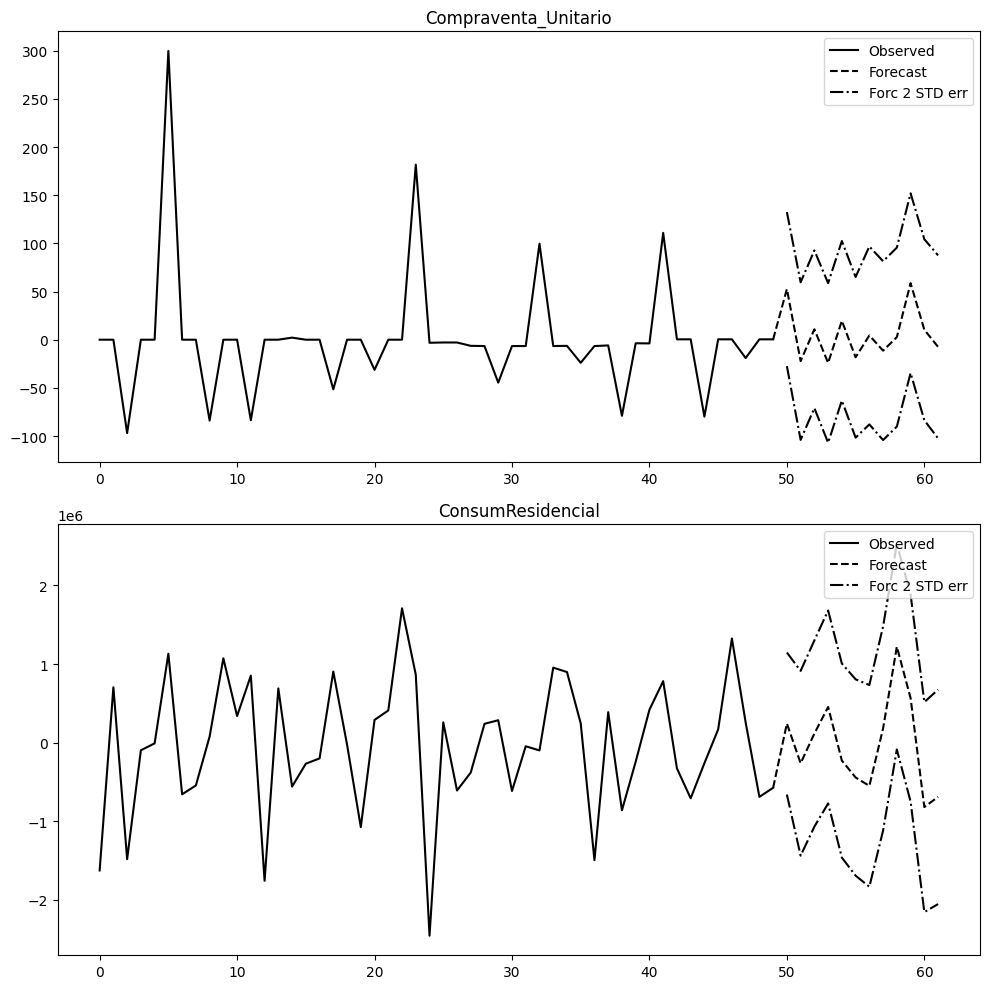

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)

In [44]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [45]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2023-04-01,2329.483206,5.329223e+06
2023-05-01,2307.263295,5.066593e+06
2023-06-01,2318.092924,5.182301e+06
2023-07-01,2293.989520,5.636201e+06
2023-08-01,2313.607813,5.407809e+06
2023-09-01,2295.333881,4.964437e+06


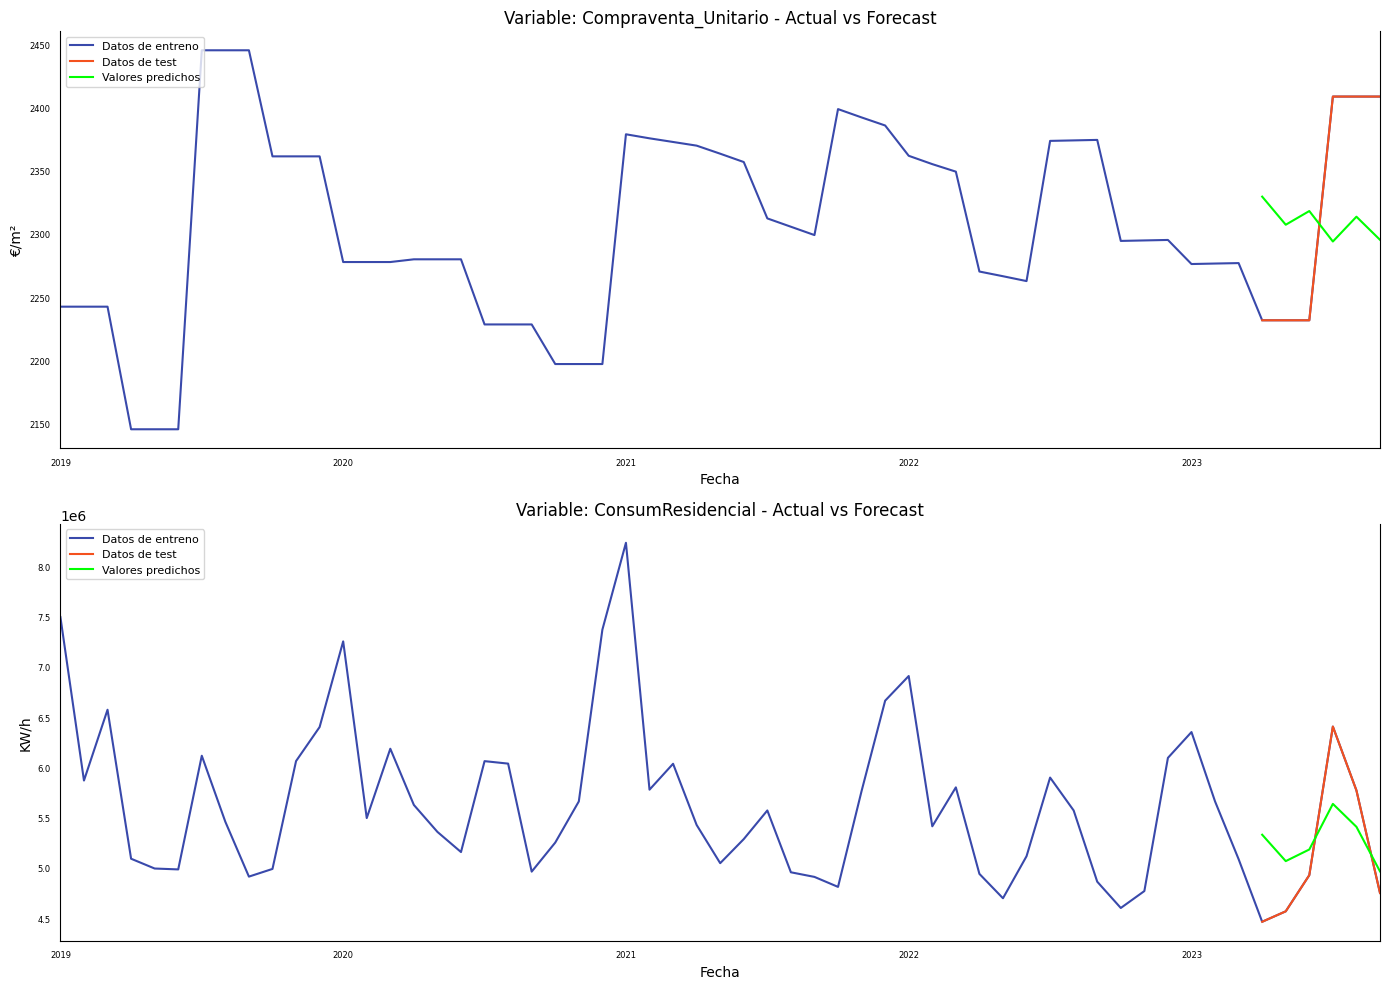

In [46]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'KW/h']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    df[col].plot(color = '#3949AB', legend = True, ax = ax)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['Datos de entreno', 'Datos de test', 'Valores predichos'], loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [47]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [48]:
for i in ['Compraventa_Unitario', 'ConsumResidencial']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , pred[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 9623.715872890938
MAE is : 97.11675322875499
RMSE is : 98.100539615697
MAPE is : 4.1745479172005275
R2 is : -0.22969116443132642

Evaluation metric for ConsumResidencial
Evaluation metric results:-
MSE is : 305674862287.99207
MAE is : 494552.941956775
RMSE is : 552878.7048602904
MAPE is : 9.722982137253716
R2 is : 0.3850094592593839



Las métricas de evaluación revelan que Compraventa_Unitario tiene una precisión razonable con un MAPE de 3.89% y un RMSE de 109.69, pero un R2 negativo indica un ajuste deficiente del modelo. Para ConsumResidencial, los errores extremadamente altos (MAE de 500,244 y RMSE de 608,783) y un R2 bajo de 0.24 muestran que el modelo es inadecuado.

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, pred)))

Mean absolute error: 247325.02935500187
Root mean squared error: 390944.2875344951


### Modelo VARMA (Auto Arima)

El modelo VARMA (Vector Autoregressive Moving Average) es una técnica estadística utilizada en análisis de series temporales que combina los modelos VAR (Vector Autoregressive) y MA (Moving Average). Es especialmente útil cuando se trata de series temporales múltiples, permitiendo modelar la interdependencia entre varias series a lo largo del tiempo junto con términos de error autocorrelacionados.



In [50]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00


#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [51]:
import pmdarima as pm

In [52]:
pq = []
for name in ['Compraventa_Unitario', 'ConsumResidencial']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                d=0,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=936.548, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=577.795, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=579.794, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=578.354, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=562.469, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=570.395, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=561.495, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=589.789, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=561.644, Time=0.12 sec
 ARIMA(2,0,1)

In [53]:
pq

[(1, 0, 0), (0, 0, 2)]

* **Compraventa_Unitario**, el mejor modelo identificado es un ARIMA(1,0,0) con intercepto. Esto sugiere que la serie puede ser modelada efectivamente utilizando un término autorregresivo, sin necesidad de diferenciación ni de un componente de media móvil.

* **ConsumResidencial**, el mejor modelo es un ARIMA(0,0,2) con intercepto. Esto indica que la serie puede ser modelada sin términos autorregresivos ni de diferenciación, pero con dos términos de media móvil.

#####Seleccion del modelo

In [54]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [55]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','ConsumResidencial']], order=(1,0)).fit(disp=False)

In [56]:
model.summary()

Dep. Variable:,"['Compraventa_Unitario', 'ConsumResidencial']",No. Observations:,50
Model:,VAR(1),Log Likelihood,-1026.325
,+ intercept,AIC,2070.650
Date:,"Tue, 28 May 2024",BIC,2087.858
Time:,18:05:03,HQIC,2077.203
Sample:,02-01-2019,,
,- 03-01-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.01, 0.07",Jarque-Bera (JB):,"287.93, 0.33"
Prob(Q):,"0.92, 0.79",Prob(JB):,"0.00, 0.85"
Heteroskedasticity (H):,"0.23, 0.88",Skew:,"2.63, -0.20"


#### Valores predichos

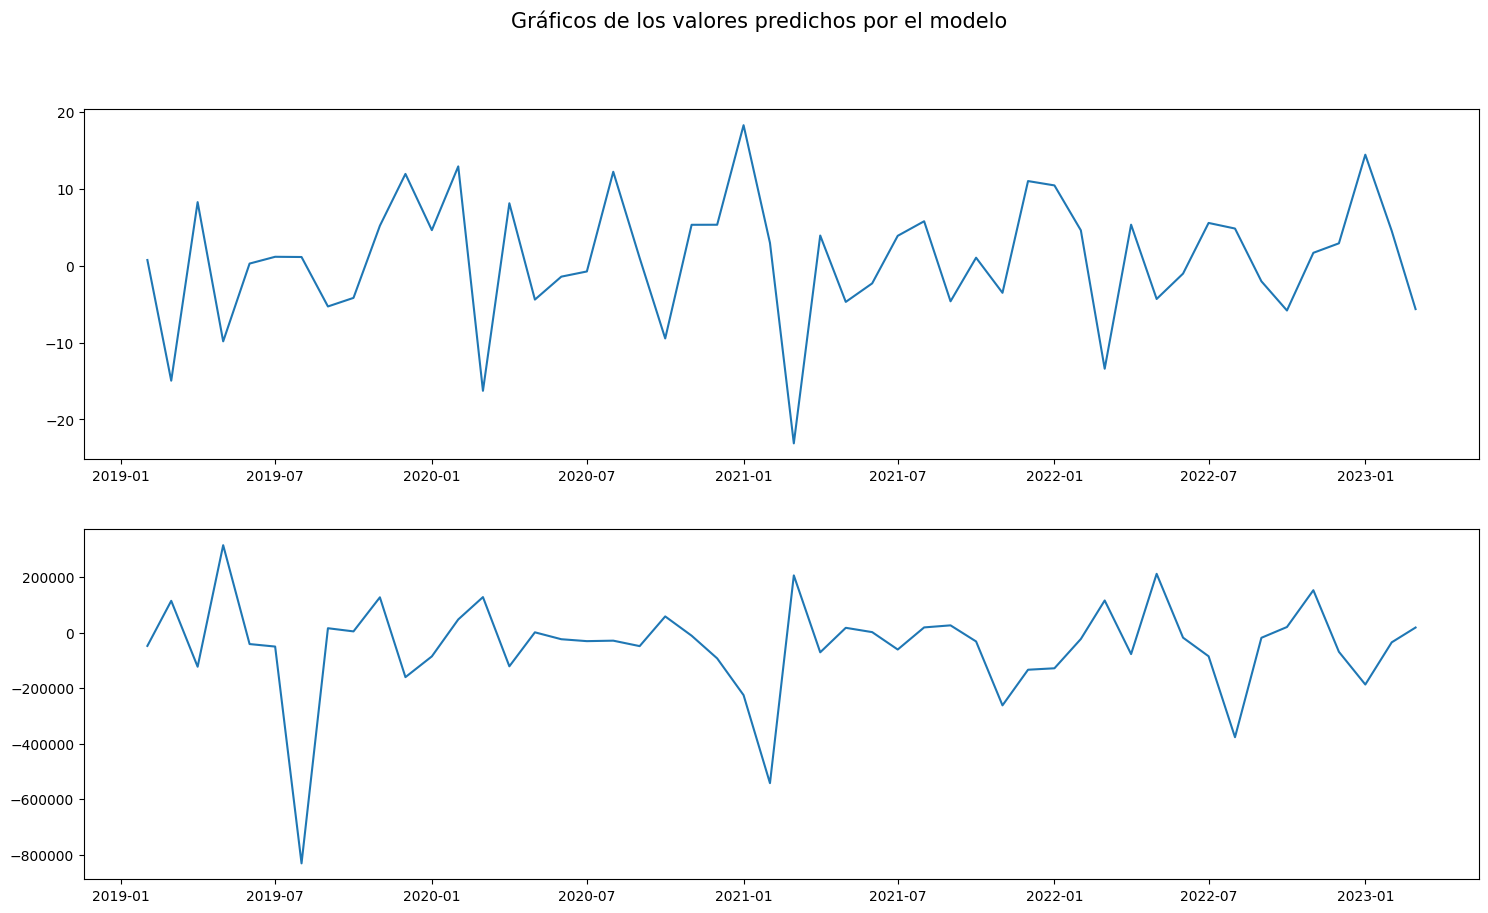

In [57]:
y_fitted = model.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


In [58]:
result = model.forecast(steps = 6)

In [59]:
result

,Compraventa_Unitario,ConsumResidencial
2023-04-01,-4.486301,6475.824580
2023-05-01,1.489235,-41931.827389
2023-06-01,0.779598,-50251.821148
2023-07-01,0.723637,-47832.034043
2023-08-01,0.749884,-47954.236423
2023-09-01,0.747669,-47999.983459


#### Invertiendo la transformacion de los pronosticos a la escala original

In [60]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [61]:
res = inverse_diff(X_train[['Compraventa_Unitario', 'ConsumResidencial']],result,False)

In [62]:
res

,Compraventa_Unitario,ConsumResidencial
2023-04-01,2272.433074,5.092402e+06
2023-05-01,2273.922309,5.050470e+06
2023-06-01,2274.701907,5.000218e+06
2023-07-01,2275.425545,4.952386e+06
2023-08-01,2276.175429,4.904432e+06
2023-09-01,2276.923098,4.856432e+06


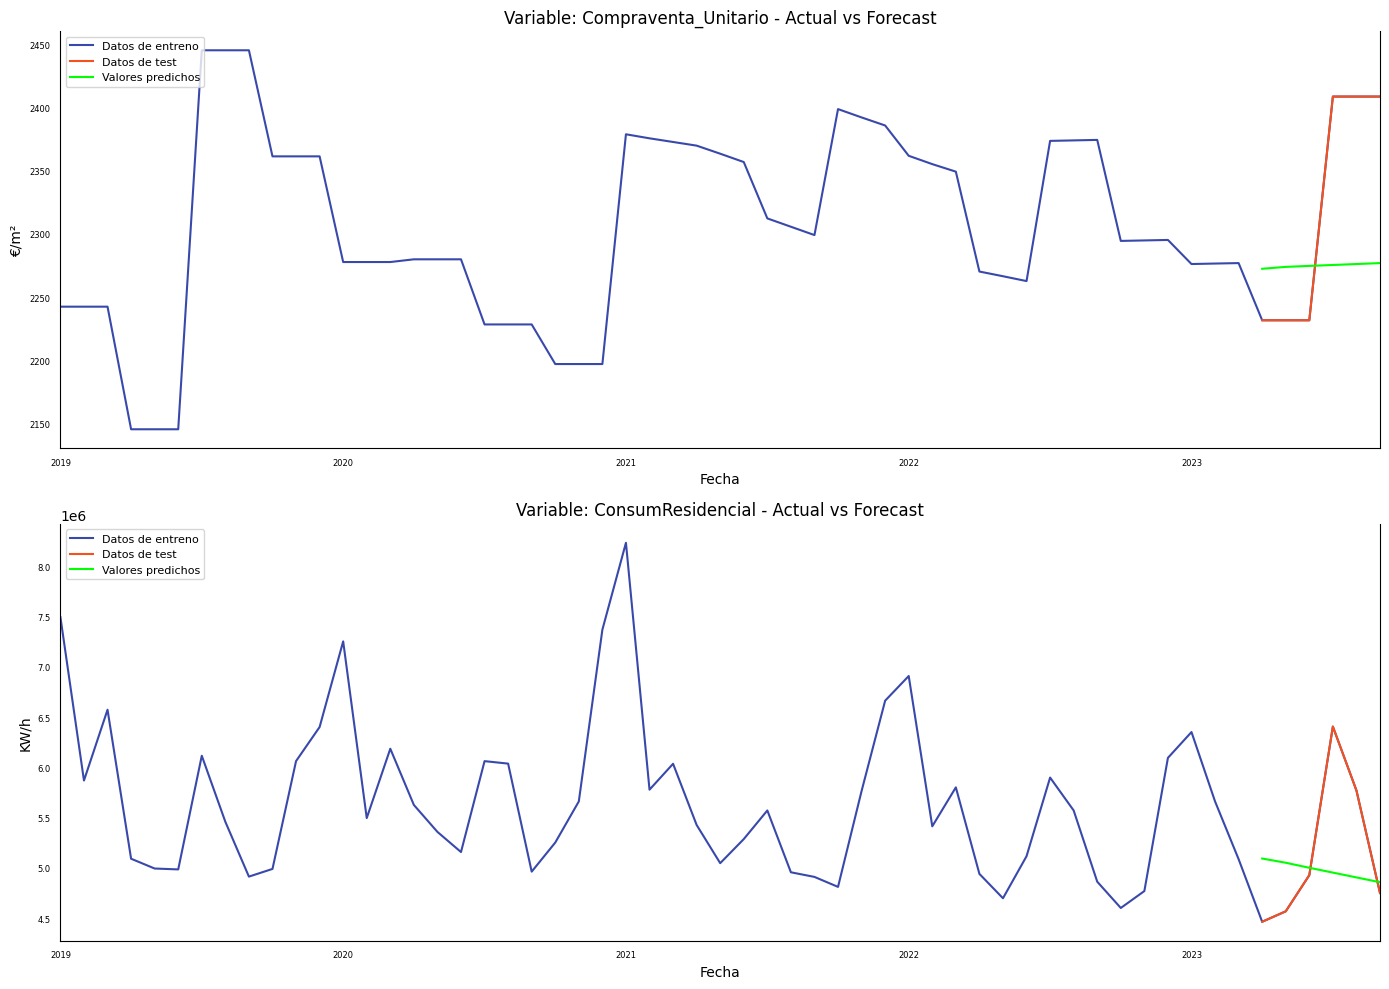

In [63]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'KW/h']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    df[col].plot(color = '#3949AB', legend = True, ax = ax)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['Datos de entreno', 'Datos de test', 'Valores predichos'], loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [64]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [65]:
for i in ['Compraventa_Unitario','ConsumResidencial']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 9653.642509085803
MAE is : 87.22092093019705
RMSE is : 98.25295165584494
MAPE is : 3.690306013044741
R2 is : -0.2335151052662423

Evaluation metric for ConsumResidencial
Evaluation metric results:-
MSE is : 584501268925.595
MAE is : 601912.9146230604
RMSE is : 764526.8268187814
MAPE is : 11.018104543721003
R2 is : -0.1759643849989192



El modelo para Compraventa_Unitario muestra precisión moderada con bajo MAE y RMSE, pero su muy bajo R² indica que casi no explica la variabilidad de los datos. Por otro lado, el modelo para ConsumResidencial revela un rendimiento deficiente con errores extremadamente altos en todas las métricas y un R² negativo, lo que señala que el modelo es inadecuado para predecir esta serie de tiempo.

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 301000.06777199527
Root mean squared error: 540602.1081068948


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_Unitario y consumo electrico residencial tenemos que:

- Se ha comprobado que las variables tienen correlacion inversa.
- Se ha realizado el test de Cointegracion y se ha demostrado que las series no estan cointegradas, lo que desestima la opcion de aplicar un modelo VECM
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad, a partir de una diferenciacion de primer orden lo que las hace aptas para aplicar los dos modelos VAR y VARMA.
- Modelo VAR: Las metricas de evaluacion del modelo VAR, son bastante satisfactorias para la variable de Compraventa, y no tanto para la variable del paro registrado
- Modelo VARMA: las metricas de evaluación nos advierten de que el modelo obtiene un rendimiento deficiente. Lo que de muestra que los datos tienen una estructura que puede ser capturada unicamente por relaciones autoregresivas sin la necesidad de componentes de medias moviles.

